
<h2 align=center>Segmenting and Exploring specific areas of the city of Vancouver</h2>
<h4 align=center>Final Capstone Project - The Battle of Neighborhoods</h4>
<h5 align=center>David Silva</h5>


### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Introduction</a>

2.  <a href="#item2">Business Understanding</a>

3.  <a href="#item3">Data Understanding / Preparation</a>

4.  <a href="#item4">Exploratory Data Analysis</a>

5.  <a href="#item5">Conclusion</a>

6.  <a href="#item6">References</a>
    </font>
    </div>
    
 


<a id="#item1"></a>

<a id='item1'></a>

### 1. Introduction

The city of Vancouver is part of the province of British Columbia and has the highest population density in Canada, with more than 5,400 people per square kilometer. It is one of the cities with the greatest ethnic and linguistic diversity in Canada, with 52% of the population speaking a first language other than English. With its panoramic views, mild climate and friendly people, Vancouver was one of the venues for famous international events such as the 2010 Winter Olympics and the 2010 Winter Paralympic Games.

<a id='item2'></a>

### 2.   Business Understanding

According to the official page of the city of Vancouver, the city consists of a number of smaller neighborhoods and communities, where these neighborhoods being divided into 22 distinct areas. We will focus only on these 22 neighborhoods.

Our client is interested in exploring the neighborhood with more different places and from there, exploring the best hotels and restaurants  with the best reviews during their stay in Vancouver. We will also find Italian restaurant options in the region, in case he is interested.

Therefore, our main objective is to explore the neighborhoods of the city of Vancouver trying to find the most diverse and from there to explore the best places to visit. To do this, we will initially use the k-means clustering algorithm to segment neighborhoods according to the most common places, using the resources of the Foursquare API, to collect information from the various places located in Vancouver. We will use the map feature (folium) to better visualize the results.


<a id='item3'></a>

### 3.   Data Understanding / Preparation

Before we start collecting the data necessary for our study, let's run the list of libraries used in this study:

In [ ]:
#!conda install scikit-learn==0.20
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np # library to handle data in a vectorized manner
import requests
import zipfile as zp

# Elbow Method for K means
try:
  from yellowbrick.cluster import KElbowVisualizer
except:
  !pip install -U scikit-learn
  !pip install -U yellowbrick
  from yellowbrick.cluster import KElbowVisualizer
#
import json # library to handle JSON files
from pandas import json_normalize 
#
try:
  from geopy.geocoders import Nominatim
except:
  !conda install -c conda-forge geopy --yes 
  from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
#
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
#
# import k-means from clustering stage
from sklearn.cluster import KMeans
#
try:
  import folium
except:
  !conda install -c conda-forge folium=0.5.0 --yes
  import folium # map rendering library
#    
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import sklearn.utils    
from sklearn.metrics import silhouette_score
from itertools import product

    
print('Libraries imported.')

First of all, let's manually get the coordinates of the 22 neighborhoods in the city of Vancouver since I couldn't find this information already in a table. For this, I collected the latitude and longitude of the 22 neighborhoods (Wikipedia) and consolidated it into a table, which we can obtain as shown below:


In [2]:
url = 'https://raw.githubusercontent.com/expressosub/sharing_notebook/main/geocode_vancouver.csv'
vancouver_geo = pd.read_csv(url)


#print size of data
print(vancouver_geo.shape)
vancouver_geo


(22, 3)


,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.257100,-123.166200
1,Downtown,49.284167,-123.121111
2,Dunbar-Southlands,49.250000,-123.185000
3,Fairview,49.264000,-123.130000
4,Grandview-Woodland,49.275000,-123.067000
5,Hastings-Sunrise,49.281126,-123.044070
6,Kensington-Cedar Cottage,49.250000,-123.066670
7,Kerrisdale,49.216667,-123.150000
8,Killarney,49.223000,-123.039000
9,Kitsilano,49.266667,-123.166667


Now we’re going to put all of these neighborhoods on a centralized map of Vancouver. Let's use geopy library to get the latitude and longitude values of Vancouver. But you can also do a simple google search and find these coordinates easily.

In [3]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="vc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


We will use the Folium library to overlay the neighborhoods of Vancouver as points above the map.
    

In [4]:
# create map of Vancouver using latitude and longitude values
map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(vancouver_geo['Latitude'], vancouver_geo['Longitude'], vancouver_geo['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

Very cool . Now what we need is to collect information from each neighborhood to be able to understand and segment them into groups. We will use the Foursquare API tool, for that you need to have your credentials to be able to make your calls. As I am using a free version, limits are imposed on the data collection. You can choose to register your credit card (as I did) in order to have better access to data.

In [13]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210119'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Now that we are able to make our calls on Fourquare Api, we will collect the most common places in each Vancouver neighborhood (limited within a radius of 600 meters) using the function below:

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


vancouver_venues = getNearbyVenues(names=vancouver_geo['Neighborhood'],
                                   latitudes=vancouver_geo['Latitude'],
                                   longitudes=vancouver_geo['Longitude']
                                  )

Arbutus Ridge
Downtown
Dunbar-Southlands
Fairview
Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Strathcona
Sunset
Victoria-Fraserview
West End
West Point Grey


In [113]:
print(vancouver_venues.shape)
vancouver_venues.head()

(645, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.2571,-123.1662,Sweet Obsession Cakes & Pastries,49.257756,-123.165314,Dessert Shop
1,Arbutus Ridge,49.2571,-123.1662,Yuwa Japanese Cuisine,49.257938,-123.167884,Japanese Restaurant
2,Arbutus Ridge,49.2571,-123.1662,Carnarvon Park,49.257678,-123.171502,Baseball Field
3,Arbutus Ridge,49.2571,-123.1662,Starbucks,49.257920,-123.168210,Coffee Shop
4,Arbutus Ridge,49.2571,-123.1662,Subway,49.258050,-123.168586,Sandwich Place


Let's find out how many unique categories can be curated from all the returned venues

In [8]:
vancouver_venues.groupby('Neighborhood')['Venue Category'].agg(['nunique']).sort_values(['nunique'],ascending=False).rename(columns={'nunique':'Unique Categories Venues'})

,Unique Categories Venues
Neighborhood,
Downtown,60
West End,43
Kitsilano,43
Grandview-Woodland,39
Mount Pleasant,34
Hastings-Sunrise,30
Fairview,26
Sunset,22
Dunbar-Southlands,17


It seems that the Downton neighborhood has the most distinct places, followed by Kitsliano. Let's see what places and quantities our search returned to the Downtown neighborhood (the top 30 places).

In [9]:
vancouver_downtown = vancouver_venues[vancouver_venues['Neighborhood']=='Downtown']
vancouver_downtown['Venue Category'].value_counts()[0:30]

Hotel                  9
Clothing Store         5
Dessert Shop           4
Café                   4
Food Truck             4
Cosmetics Shop         3
Coffee Shop            3
Restaurant             3
Steakhouse             3
Concert Hall           3
Gym                    2
Japanese Restaurant    2
Toy / Game Store       2
Seafood Restaurant     2
Burger Joint           2
Sandwich Place         2
French Restaurant      2
Italian Restaurant     2
Donut Shop             2
Bakery                 1
Lebanese Restaurant    1
Miscellaneous Shop     1
Yoga Studio            1
Jewelry Store          1
Breakfast Spot         1
Optical Shop           1
Art Gallery            1
Hawaiian Restaurant    1
Movie Theater          1
Hot Dog Joint          1
Name: Venue Category, dtype: int64

<a id='item4'></a>

### 4. Exploratory Data Analysis

#### 4.1 First part: cluster Vancouver neighborhoods

Before specifically exploring the Downtown neighborhood, let's try to cluster Vancouver neighborhoods based on the most common places in each neighborhood.

In [10]:
# one hot encoding
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = vancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
col = vancouver_onehot.pop("Neighborhood")
vancouver_onehot.insert(0, col.name, col)


#let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
vancouver_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()
print(vancouver_grouped.shape)
vancouver_grouped.head()

(22, 160)


,Neighborhood,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flower Shop,Food,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Nail Salon,New American Restaurant,Noodle House,Office,Optical Shop,Outdoor Supply Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.166667,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.166667,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.166667,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.166667,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.166667,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00
1,Downtown,0.01,0.0,0.01,0.010000,0.000000,0.000000,0.000000,0.0,0.010000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.000000,0.0,0.01,0.020000,0.0,0.0,0.040000,0.000000,0.000000,0.0,0.0,0.010000,0.0,0.0,0.05,0.030000,0.03,0.01,0.030000,0.000000,0.01,0.010000,0.040000,0.000000,0.0,0.0,0.02,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.04,0.020000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.020000,0.0,0.0,0.01,0.01,0.0,0.0,0.01,0.09,0.010000,0.010000,0.000000,0.0,0.020000,0.01,0.020000,0.01,0.0,0.0,0.000000,0.0,0.01,0.01,0.0,0.01,0.01,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010000,0.010000,0.01,0.0,0.01,0.000000,0.01,0.01,0.0,0.01,0.0,0.000000,0.000000,0.000000,0.010000,0.0,0.01,0.0,0

In [11]:
#write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_grouped['Neighborhood']

for ind in np.arange(vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Dessert Shop,Baseball Field,Japanese Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Food,Flower Shop,Fish & Chips Shop,Field
1,Downtown,Hotel,Clothing Store,Café,Food Truck,Dessert Shop,Steakhouse,Restaurant,Concert Hall,Coffee Shop,Cosmetics Shop
2,Dunbar-Southlands,Bank,Diner,Grocery Store,Café,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Restaurant,Coffee Shop,Sushi Restaurant
3,Fairview,Coffee Shop,Park,Pharmacy,Japanese Restaurant,Asian Restaurant,Pet Store,Falafel Restaurant,Malay Restaurant,Camera Store,Restaurant
4,Grandview-Woodland,Coffee Shop,Pizza Place,Italian Restaurant,Park,Indian Restaurant,Café,Bakery,Theater,Japanese Restaurant,Vegetarian / Vegan Restaurant


We will determine the ideal cluster number based on the visual method called KElbowVisualizer that implements the “elbow” method by selecting the ideal number of clusters by adjusting the K-Means model within a range of values for K. In the part where in our line graph if it looks like an arm, the “elbow” (the inflection point on the curve) is a good indication of an ideal cluster number.

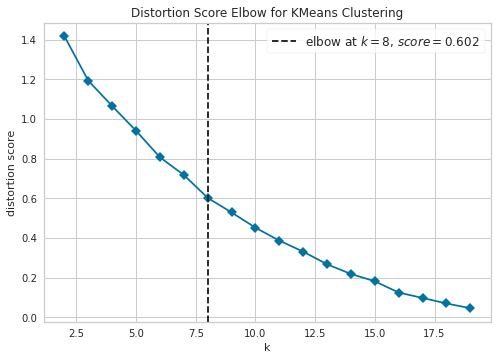

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
# Remove Neighborhood columns and prepare dataframe for clustering
vancouver_grouped_c = vancouver_grouped.drop('Neighborhood',1)

model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= False)
visualizer.fit(vancouver_grouped_c)        # Fit data to visualizer
visualizer.show()   

Let set our cluster number to 8 and create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [12]:
# set number of clusters
kclusters = 8

vancouver_grouped_clustering = vancouver_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vancouver_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = vancouver_geo

# merge vancouver_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vancouver_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,49.257100,-123.166200,3,Dessert Shop,Baseball Field,Japanese Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Food,Flower Shop,Fish & Chips Shop,Field
1,Downtown,49.284167,-123.121111,1,Hotel,Clothing Store,Café,Food Truck,Dessert Shop,Steakhouse,Restaurant,Concert Hall,Coffee Shop,Cosmetics Shop
2,Dunbar-Southlands,49.250000,-123.185000,0,Bank,Diner,Grocery Store,Café,Chinese Restaurant,Sandwich Place,Mexican Restaurant,Restaurant,Coffee Shop,Sushi Restaurant
3,Fairview,49.264000,-123.130000,1,Coffee Shop,Park,Pharmacy,Japanese Restaurant,Asian Restaurant,Pet Store,Falafel Restaurant,Malay Restaurant,Camera Store,Restaurant
4,Grandview-Woodland,49.275000,-123.067000,1,Coffee Shop,Pizza Place,Italian Restaurant,Park,Indian Restaurant,Café,Bakery,Theater,Japanese Restaurant,Vegetarian / Vegan Restaurant


Finally, let's put this information on the map, specifying each cluster with a different color.

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="OpenStreetMap")

rainbow = ["#000075","#ffe119","#9A6324","#e6194B","#800000","#3cb44b","#469990","#42d4f4"]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighborhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters



Let's explore the cluster where the Downtown neighborhood is located and we can see that our model added the neighborhoods with the most diversity of locations in that cluster.

In [20]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown,Hotel,Clothing Store,Café,Food Truck,Dessert Shop,Steakhouse,Restaurant,Concert Hall,Coffee Shop,Cosmetics Shop
3,Fairview,Coffee Shop,Park,Pharmacy,Japanese Restaurant,Asian Restaurant,Pet Store,Falafel Restaurant,Malay Restaurant,Camera Store,Restaurant
4,Grandview-Woodland,Coffee Shop,Pizza Place,Italian Restaurant,Park,Indian Restaurant,Café,Bakery,Theater,Japanese Restaurant,Vegetarian / Vegan Restaurant
5,Hastings-Sunrise,Theme Park Ride / Attraction,Burger Joint,Vietnamese Restaurant,Beer Garden,Coffee Shop,Theater,Theme Park,Event Space,Park,Fair
8,Killarney,Pharmacy,Grocery Store,Fast Food Restaurant,Sandwich Place,Salon / Barbershop,Liquor Store,Gas Station,Chinese Restaurant,Sushi Restaurant,Farmers Market
9,Kitsilano,Coffee Shop,Café,Park,Yoga Studio,Indian Restaurant,Vegetarian / Vegan Restaurant,Pub,Donut Shop,Bus Stop,Chinese Restaurant
10,Marpole,Pharmacy,Bank,Park,Public Art,Residential Building (Apartment / Condo),Fast Food Restaurant,Field,Bubble Tea Shop,Liquor Store,American Restaurant
11,Mount Pleasant,Coffee Shop,Chinese Restaurant,Indian Restaurant,Café,Taco Place,Sandwich Place,Brewery,Japanese Restaurant,Park,Pizza Place
14,Riley Park,Vietnamese Restaurant,Farmers Market,Ice Cream Shop,Gym,Playground,Chinese Restaurant,Cantonese Restaurant,Café,Skating Rink,Bus Stop
16,South Cambie,Coffee Shop,Bus Stop,Park,Light Rail Station,Gift Shop,Shopping Mall,Bank,Grocery Store,Furniture / Home Store,Bubble Tea Shop


#### 4.2 Second part: Trends venues in  Downtown Vancouver

As a second part of our study, we will explore the Downton neighborhood. We will collect information related to the evaluations of each place in the space of 600 meters in radius according to our latest results. When collecting this information using Foursquare Api, it is only possible to obtain this information more quickly if you register your credit card. As I only made a premium call, I subsequently stored the results in a csv file, so as not to exceed my daily call limits and end up being charged to the credit card. Stay alert.

In [21]:
import pandas as pd

data_vancouver = pd.read_csv('vancouver_venues_characteristic.csv')
dataframe_filtered = pd.read_csv('vancouver_venues_dataframe_filtered.csv')

First, let's put in a dataframe the information of 100 venues in range of 650 meters in Downtown neighborhood.

In [ ]:
#Latitude and longitude values of Downtown 
neighborhood_latitude = 49.284167
neighborhood_longitude = -123.12111100000001

limit = 100 # limit of number of venues returned by Foursquare API
radius = 650 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    limit)

results_downtown= requests.get(url).json()
#'There are {} places around '.format(len(results_downtown['response']['groups'][0]['items']))


In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
items = results_downtown['response']['groups'][0]['items']  


dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

#filter column of interest
filtered_columns_2 = ['id','name','categories','lat','lng','distance','postalCode','cc','city','state','country']
dataframe_filtered = dataframe_filtered.loc[:, filtered_columns_2]


In [23]:
print(dataframe_filtered.shape)
dataframe_filtered.head(5)

(100, 11)


,id,name,categories,lat,lng,distance,postalCode,cc,city,state,country
0,4d5ec8ce29ef236ae0cb9059,Rosewood Hotel Georgia,Hotel,49.283429,-123.118911,179,V6C 1P7,CA,Vancouver,BC,Canada
1,4aa7b152f964a520fa4c20e3,Hyatt Regency Vancouver,Hotel,49.284934,-123.120407,99,V6C 2R7,CA,Vancouver,BC,Canada
2,4d2cce46ae3a8cfa4067bf70,Hawksworth Restaurant,Lounge,49.283362,-123.119462,149,V6P 1C7,CA,Vancouver,BC,Canada
3,507f01b790e746e865f024c3,Victoria's Secret,Lingerie Store,49.283372,-123.122491,133,V6Z 1X5,CA,Vancouver,BC,Canada
4,4adbc696f964a5208f2a21e3,Rocky Mountain Chocolate Factory,Dessert Shop,49.283626,-123.123306,170,V6E 1A9,CA,Vancouver,BC,Canada


Now for each place, we will collect information related to the variables "rating", "tips.count", "likes.count". The description of these variations can be seen below:

<ul>
<li>rating: Numerical rating of the venue (0 through 10).</li>
<li>tips.count : Contains the number of tips on the respective venue.</li>
<li>likes.count: The count of users who have liked this venue.</li>
</ul>

we will collect the result of our api call from which we collect the characteristics of each place and join with our previous table. The result can be seen below (the first 10 lines).

In [ ]:
venues_ids= dataframe_filtered['id']

pd.set_option('display.max_colwidth', None)
filtered_columns = ['id', 'name','description','rating','stats.tipCount','tips.count','likes.count','location.address','location.postalCode','location.city','price.tier','price.message','price.currency','reasons.count','ReasonItem','Categorie']
data_vancouver = pd.DataFrame()
tips_filtered = []

for venue_id in venues_ids:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
 
        categorie = []
        reasonitem = []
        #tips_filtered = []
        result_data = json_normalize(result['response']['venue'])
        tips_filtered = result_data.reindex(columns = filtered_columns)
        
        
        reasonitem.append([b['summary'] for b in result_data['reasons.items'][0] if 'summary' in b]) 
        categorie.append([d['name'] for d in result_data['categories'][0] if 'name' in d]) 


        tips_filtered['ReasonItem'] = reasonitem
        tips_filtered['Categorie'] = categorie
        
        data_vancouver=data_vancouver.append(tips_filtered,ignore_index=True)

        
        
    except IndexError:
        print('No data available for id=',ID)

In [25]:
data_merge = data_vancouver.merge(dataframe_filtered[['id', 'categories','lat','lng']], on='id', how='left')

data_merge = data_merge.drop(columns=['Categorie'])


df1 = data_merge.filter(['id','name','lat','lng','categories','rating','tips.count','likes.count'])
df1.head()


,id,name,lat,lng,categories,rating,tips.count,likes.count
0,4d5ec8ce29ef236ae0cb9059,Rosewood Hotel Georgia,49.283429,-123.118911,Hotel,9.3,29,109
1,4aa7b152f964a520fa4c20e3,Hyatt Regency Vancouver,49.284934,-123.120407,Hotel,9.1,33,197
2,4d2cce46ae3a8cfa4067bf70,Hawksworth Restaurant,49.283362,-123.119462,Lounge,9.1,66,203
3,507f01b790e746e865f024c3,Victoria's Secret,49.283372,-123.122491,Lingerie Store,8.9,22,135
4,4adbc696f964a5208f2a21e3,Rocky Mountain Chocolate Factory,49.283626,-123.123306,Dessert Shop,8.9,17,45


we are going to rearrange the data so that each category is a dummy variable and group them according to the id. This procedure is necessary to perform the necessary steps for our Kmeans cluster model.

In [26]:
# one hot encoding
downtown_onehot = pd.get_dummies(df1[['categories']], prefix="", prefix_sep="")

# add id column back to dataframe
downtown_onehot['id'] = df1['id'] 

# move neighborhood column to the first column
col = downtown_onehot.pop("id")
downtown_onehot.insert(0, col.name, col)


#let's group rows by id and by taking the mean of the frequency of occurrence of each category
downtown_grouped = downtown_onehot.groupby('id').mean().reset_index()
print(downtown_grouped.shape)
downtown_grouped.head()

(100, 57)


,id,American Restaurant,Art Gallery,Arts & Crafts Store,Bakery,Bookstore,Breakfast Spot,Building,Burger Joint,Café,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Donut Shop,Electronics Store,Food Truck,French Restaurant,Gym,Hawaiian Restaurant,Health Food Store,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Mediterranean Restaurant,Miscellaneous Shop,Movie Theater,New American Restaurant,Noodle House,Optical Shop,Park,Pizza Place,Plaza,Poke Place,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Spa,Steakhouse,Taco Place,Tea Room,Thai Restaurant,Toy / Game Store,Yoga Studio
0,4aa17172f964a520904020e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4aa6f2c7f964a5209b4b20e3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4aa73016f964a520324c20e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4aa733fbf964a520444c20e3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4aa73bb9f964a5206b4c20e3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:

downtown_merge = downtown_grouped.merge(df1[["id","name","rating","tips.count","likes.count"]], on='id', how='left')

# move name column to the first column
col_ = downtown_merge.pop("name")
downtown_merge.insert(1, col_.name, col_)

In [74]:
downtown_merge.head()

,id,name,American Restaurant,Art Gallery,Arts & Crafts Store,Bakery,Bookstore,Breakfast Spot,Building,Burger Joint,Café,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Donut Shop,Electronics Store,Food Truck,French Restaurant,Gym,Hawaiian Restaurant,Health Food Store,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Mediterranean Restaurant,Miscellaneous Shop,Movie Theater,New American Restaurant,Noodle House,Optical Shop,Park,Pizza Place,Plaza,Poke Place,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Spa,Steakhouse,Taco Place,Tea Room,Thai Restaurant,Toy / Game Store,Yoga Studio,rating,tips.count,likes.count
0,4aa17172f964a520904020e3,JOEY Burrard,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.2,69,181
1,4aa6f2c7f964a5209b4b20e3,Vancouver Art Gallery,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.7,92,432
2,4aa73016f964a520324c20e3,Scotiabank Theatres,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.3,102,672
3,4aa733fbf964a520444c20e3,Commodore Ballroom,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.8,33,259
4,4aa73bb9f964a5206b4c20e3,SEPHORA,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.8,11,57


In [75]:
downtown_merge.shape

(100, 61)

The cluster number that we will use in our model is shown below, after visually looking through the KElbowVisualizer graph.

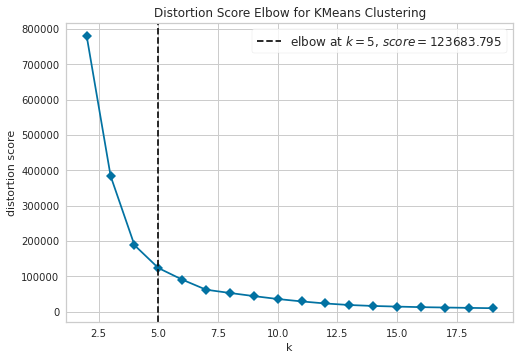

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [137]:
# # Remove id,name columns and prepare dataframe for clustering
downtown_merge_c = downtown_merge.drop(['id', 'name'],1)


model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= False)
visualizer.fit(downtown_merge_c)        # Fit data to visualizer
visualizer.show()  

Our choice was k = 5, and now we can proceed with Kmeans cluster modeling and Re-inserting in our database to which each cluster belongs to each respective id.

In [ ]:
 # set number of clusters
kclusters = 5

# Remove id,name columns and prepare dataframe for clustering
downtown_grouped_clustering = downtown_merge.drop(['id', 'name'],1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# add clustering labels
downtown_map = df1

downtown_map = downtown_map.insert(8, 'Cluster Labels', kmeans.labels_)

In [163]:
downtown_map.head()

,id,name,lat,lng,categories,rating,tips.count,likes.count,Cluster Labels
0,4d5ec8ce29ef236ae0cb9059,Rosewood Hotel Georgia,49.283429,-123.118911,Hotel,9.3,29,109,4
1,4aa7b152f964a520fa4c20e3,Hyatt Regency Vancouver,49.284934,-123.120407,Hotel,9.1,33,197,1
2,4d2cce46ae3a8cfa4067bf70,Hawksworth Restaurant,49.283362,-123.119462,Lounge,9.1,66,203,3
3,507f01b790e746e865f024c3,Victoria's Secret,49.283372,-123.122491,Lingerie Store,8.9,22,135,4
4,4adbc696f964a5208f2a21e3,Rocky Mountain Chocolate Factory,49.283626,-123.123306,Dessert Shop,8.9,17,45,0


We will now see on the map, how each cluster aggregates the places along the Downtown neighborhood.

In [138]:
# create map
map_clusters = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)

rainbow = ["#ffe119","#000075","#9A6324","#e6194B","#800000"]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_map['lat'], downtown_map['lng'], downtown_map['name'], downtown_map['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters


Here we can see the graph with the distribution of the clusters.

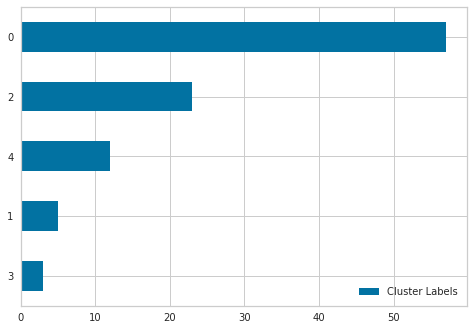

In [139]:
plot_dowtown = pd.DataFrame(downtown_map["Cluster Labels"].value_counts())
plot_dowtown.plot(kind='barh').invert_yaxis()

In [140]:
plot_dowtown

,Cluster Labels
0,57
2,23
4,12
1,5
3,3


We may also want to check which places belong to each cluster. For example, for cluster 1 the following places have been added:

In [141]:
downtown_map.loc[downtown_map['Cluster Labels'] == 1, downtown_map.columns[[1] + list(range(4, downtown_map.shape[1]))]]


,name,categories,rating,tips.count,likes.count,Cluster Labels
1,Hyatt Regency Vancouver,Hotel,9.1,33,197,1
29,JOEY Burrard,New American Restaurant,8.2,69,181,1
51,Salam Bombay,Indian Restaurant,7.8,23,45,1
56,Fairmont Pacific Rim,Hotel,9.4,69,232,1
62,Medina Café,Breakfast Spot,8.8,303,790,1


In [101]:
#downtown_map[downtown_map['categories']=="Indian Restaurant"]['Cluster Labels'].values[0]

1

We can go deeper, and want to find out which Italian restaurants are in the area. For this, a simple filter in our database returns the following table:

In [128]:
downtown_map[downtown_map['categories']=="Italian Restaurant"]

,id,name,lat,lng,categories,rating,tips.count,likes.count,Cluster Labels
44,4aa801e0f964a520ab4e20e3,CinCin,49.285402,-123.126035,Italian Restaurant,8.7,31,71,0
49,4aa82e4bf964a520de4f20e3,Pacifico Pizzeria Ristorante,49.282068,-123.124079,Italian Restaurant,8.2,36,72,0


We note that the two restaurants have a rating above 8 and have been aggregated in the same cluster. How would the map of these restaurants look in relation to other places in the same cluster. This we can check on the following map:

In [142]:
cluster_0 = downtown_map[downtown_map['Cluster Labels']== 0]
italian_rest = downtown_map[downtown_map['categories']=="Italian Restaurant"]


In [133]:

downtown_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15) # generate map centred around Ecco


# add the center point as a red circle mark
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    popup='Center Point',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)


# add Cluster 0 spots to the map as blue circle markers
for lat, lng, label in zip(cluster_0.lat, cluster_0.lng, cluster_0.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(downtown_map)
    

    
# add italian restaurants spots to the map as yellow circle markers
for nm, lat, lng, category, cluster  in zip(italian_rest["name"],italian_rest["lat"], italian_rest["lng"], italian_rest["categories"], italian_rest["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='yellow',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)
        


# display map
display(downtown_map)


Going the same way, we are now interested in discovering all the restaurants in the Downtown area with ratings above 8.5 and placing them on a map. We see below:

In [145]:
downtown_map[downtown_map.categories.str.contains("Restaurant") & (downtown_map.rating > 8.5)]

,id,name,lat,lng,categories,rating,tips.count,likes.count,Cluster Labels
12,4ab59f7cf964a520a97520e3,Joe Fortes Seafood & Chop House,49.285017,-123.124410,Seafood Restaurant,8.9,118,385,2
20,4aaec434f964a520346320e3,Le Crocodile Restaurant,49.282658,-123.125287,French Restaurant,9.2,31,63,2
31,5170656ae4b029a050dd8a49,The Keg Steakhouse + Bar - Dunsmuir,49.283438,-123.116363,Restaurant,8.8,33,158,2
44,4aa801e0f964a520ab4e20e3,CinCin,49.285402,-123.126035,Italian Restaurant,8.7,31,71,0
50,4b4be83af964a520fdaa26e3,Shizen Ya,49.280880,-123.124552,Japanese Restaurant,8.6,57,148,0
91,5646ab13498e460c732920e8,Ramen Danbo,49.287406,-123.129028,Ramen Restaurant,9.1,37,134,0
95,4d320c5498336dcb18401ff0,Cactus Club Cafe,49.289468,-123.117671,American Restaurant,8.6,98,466,0
97,51a7a349454a2b1f0e2449f8,Homer St. Cafe and Bar,49.278591,-123.118385,Restaurant,8.6,46,130,0


In [147]:
best_rest = downtown_map[downtown_map.categories.str.contains("Restaurant") & (downtown_map.rating > 8.5)]

In [148]:
downtown_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15) # generate map centred around Ecco


# add the center point as a red circle mark
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    popup='Center Point',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)


# add the best restaurants spots to the map as blue circle markers
for nm, lat, lng, category, cluster  in zip(best_rest["name"],best_rest["lat"], best_rest["lng"], best_rest["categories"], best_rest["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)
        


# display map
display(downtown_map)

and finally, following the same recipe, we will find all hotels with a rating above 8.5 and distribute them on a map.

In [164]:
downtown_map[downtown_map.categories.str.contains("Hotel") & (downtown_map.rating > 8.5)]

,id,name,lat,lng,categories,rating,tips.count,likes.count,Cluster Labels
0,4d5ec8ce29ef236ae0cb9059,Rosewood Hotel Georgia,49.283429,-123.118911,Hotel,9.3,29,109,4
1,4aa7b152f964a520fa4c20e3,Hyatt Regency Vancouver,49.284934,-123.120407,Hotel,9.1,33,197,1
7,4ba59d68f964a520bd1639e3,Wedgewood Hotel,49.282163,-123.122237,Hotel,9.0,7,17,2
11,4af0f4e4f964a5204ae021e3,The Fairmont Hotel Vancouver,49.283805,-123.120944,Hotel,8.6,64,198,3
21,4acd3910f964a5207dcb20e3,Shangri-La Hotel,49.285934,-123.124081,Hotel,8.7,28,83,0
42,4b18a7acf964a52002d523e3,Loden Hotel,49.287690,-123.123574,Hotel,9.1,20,54,4
54,4b7235fef964a52010742de3,L'Hermitage,49.280139,-123.117480,Hotel,9.3,16,37,4
56,4bbcbcf88ec3d13ab0261b28,Fairmont Pacific Rim,49.288227,-123.116932,Hotel,9.4,69,232,1


In [159]:
best_hotel = downtown_map[downtown_map.categories.str.contains("Hotel") & (downtown_map.rating > 8.5)]

In [160]:
downtown_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15) # generate map centred around Ecco


# add the center point as a red circle mark
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    popup='Center Point',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)


# add the best hotels spots to the map as blue circle markers
for nm, lat, lng, category, cluster  in zip(best_hotel["name"],best_hotel["lat"], best_hotel["lng"], best_hotel["categories"], best_hotel["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)
        


# display map
display(downtown_map)

If we already found these three possibilities, we will put them all on a map, so we can show our customer the location of the best hotels, the best restaurants and the Italian restaurants present in the region.

In [166]:
downtown_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15) # generate map centred around Ecco


# add the center point as a red circle mark
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    popup='Center Point',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)


# add the best hotels spots to the map as blue circle markers
for nm, lat, lng, category, cluster  in zip(best_hotel["name"],best_hotel["lat"], best_hotel["lng"], best_hotel["categories"], best_hotel["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)
        
# add the best restaurants spots to the map as blue circle markers
for nm, lat, lng, category, cluster  in zip(best_rest["name"],best_rest["lat"], best_rest["lng"], best_rest["categories"], best_rest["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='red',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)
        
# add italian restaurants spots to the map as yellow circle markers
for nm, lat, lng, category, cluster  in zip(italian_rest["name"],italian_rest["lat"], italian_rest["lng"], italian_rest["categories"], italian_rest["Cluster Labels"]):
    
        title=", Category:" + str(category)
    
    
        label = folium.Popup(str(nm)  + title + ' Cluster ' + str(cluster), parse_html=True)
    
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            fill=True,
            color='yellow',
            fill_color='black',
            fill_opacity=0.6
            ).add_to(downtown_map)

# display map
display(downtown_map)

<a id='item5'></a>

### 5.   Conclusion

In conclusion, this study aimed to find the best places to go using the Foursquare API as a tool. We can see how easy it is to find and map your searches to your needs. For example, we can place another neighborhood in Vancouver and easily find the best places from a central point.

One point to clarify is that not all calls in the Foursquare API are free, so be careful not to spend a lot of money when making a call within a for loop, for example.

As future changes in this research, we could use a different type of data cluster model different from Kmeans cluster, such as: density-based clustering algorithms like DBSCAN or HDBSCAN.

<a id='item6'></a>

### 6.   References



<ul>
<li>https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver</li>
<li>https://vancouver.ca/news-calendar/areas-of-the-city.aspx</li>
<li>https://developer.foursquare.com/docs/api-reference/venues/details</li>
</ul>